Loading images...

Part 1: Extracting Features


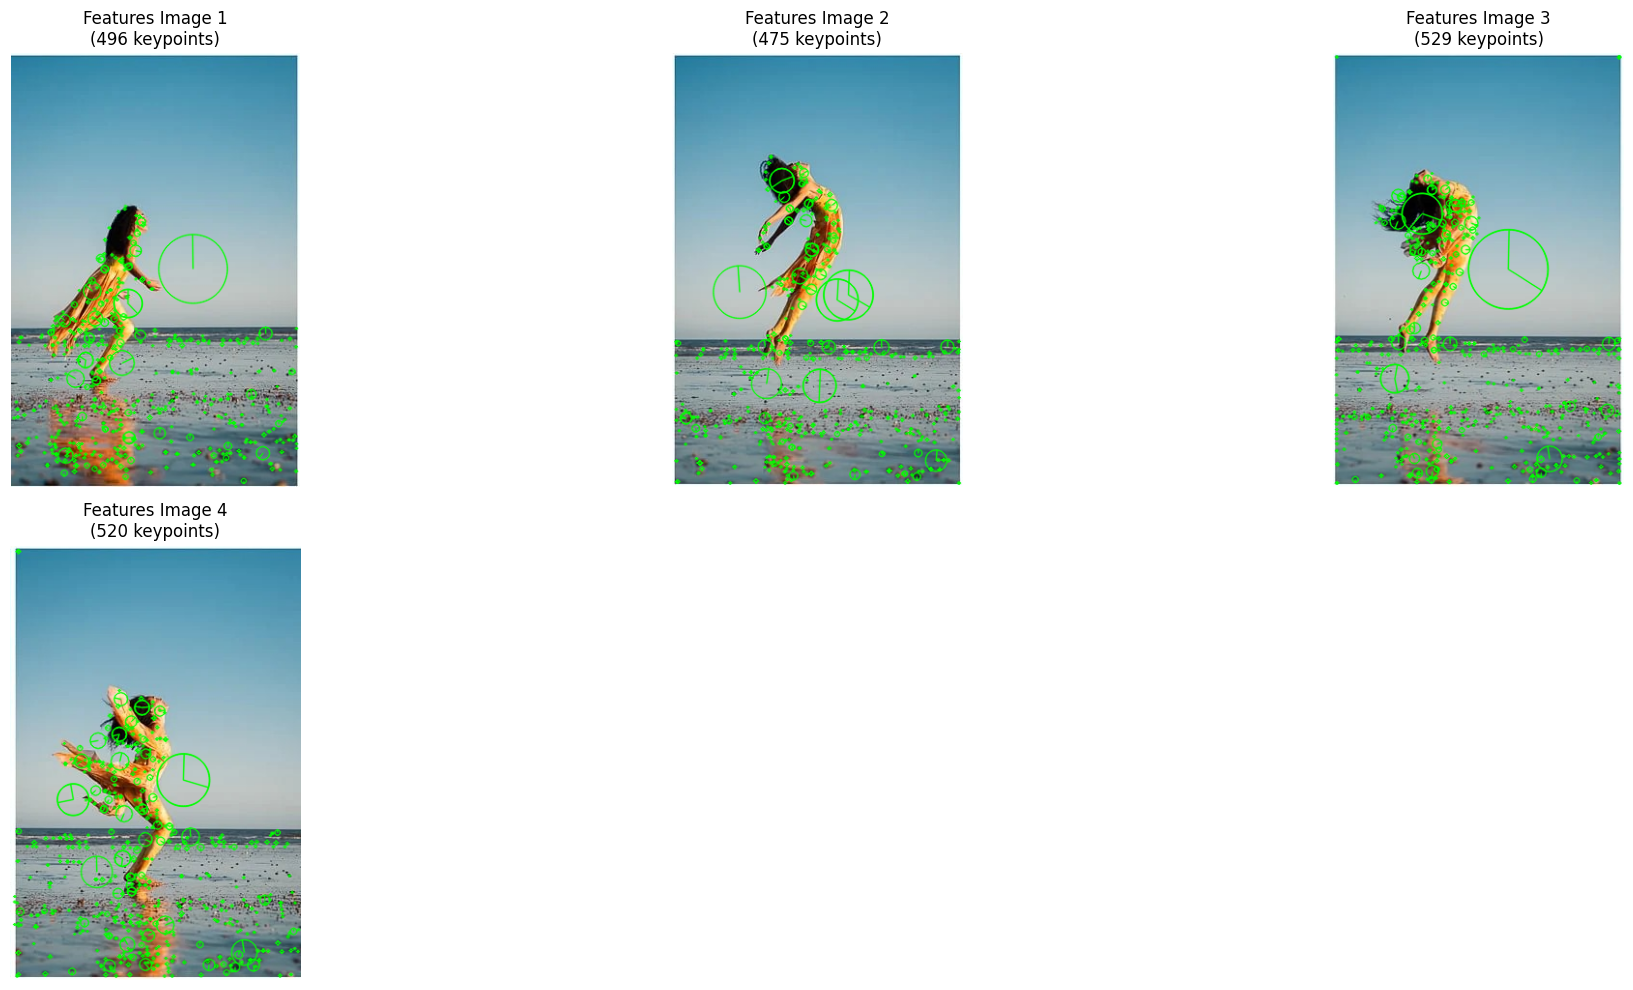


Part 2: Feature Matching


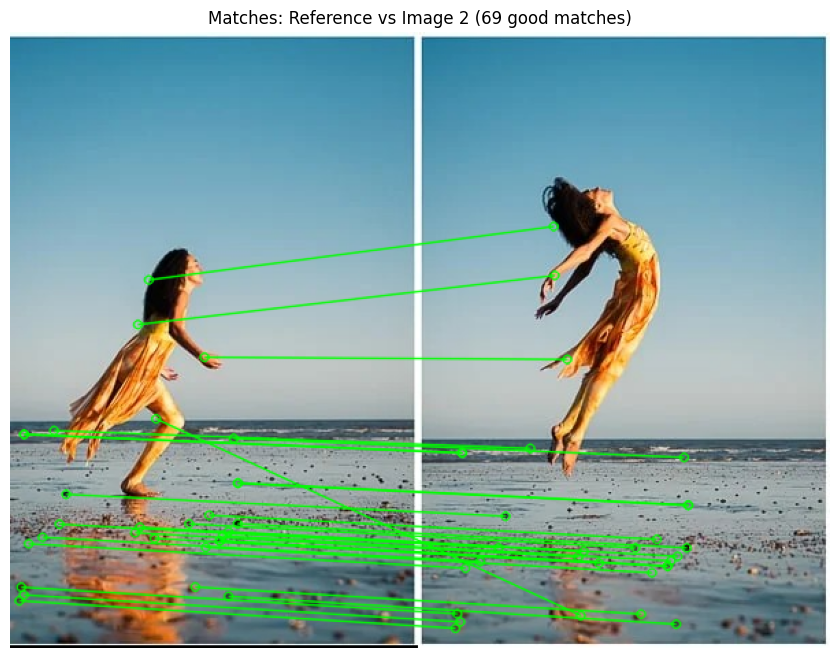


Part 3: RANSAC Transform for Image 2


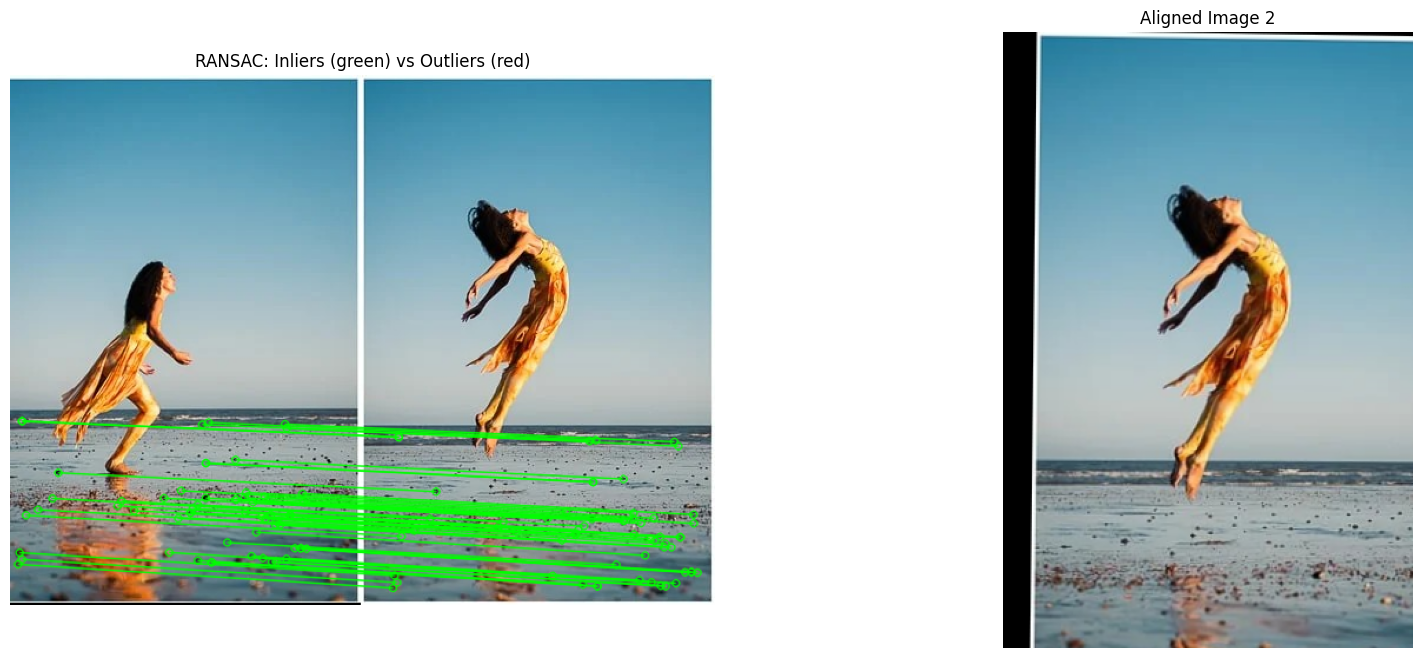

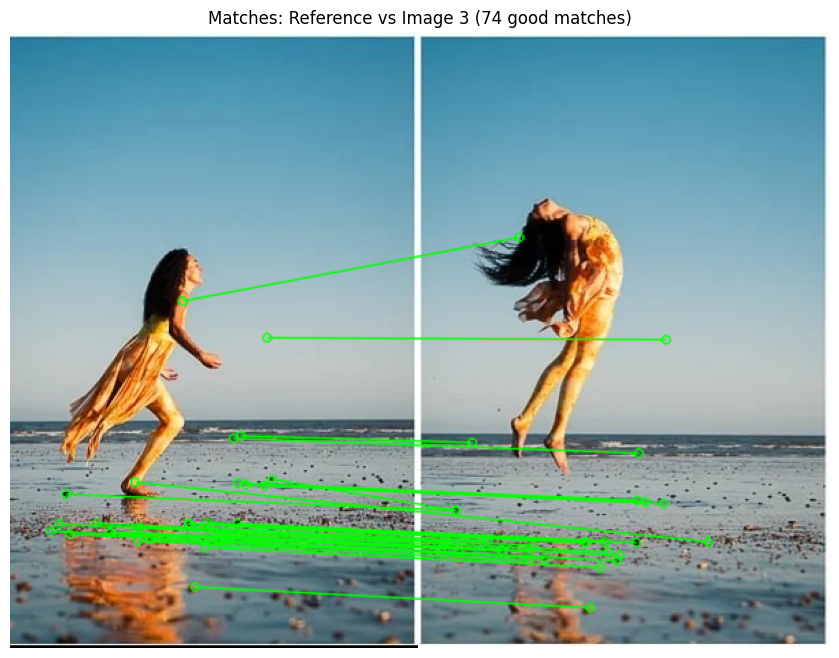


Part 3: RANSAC Transform for Image 3


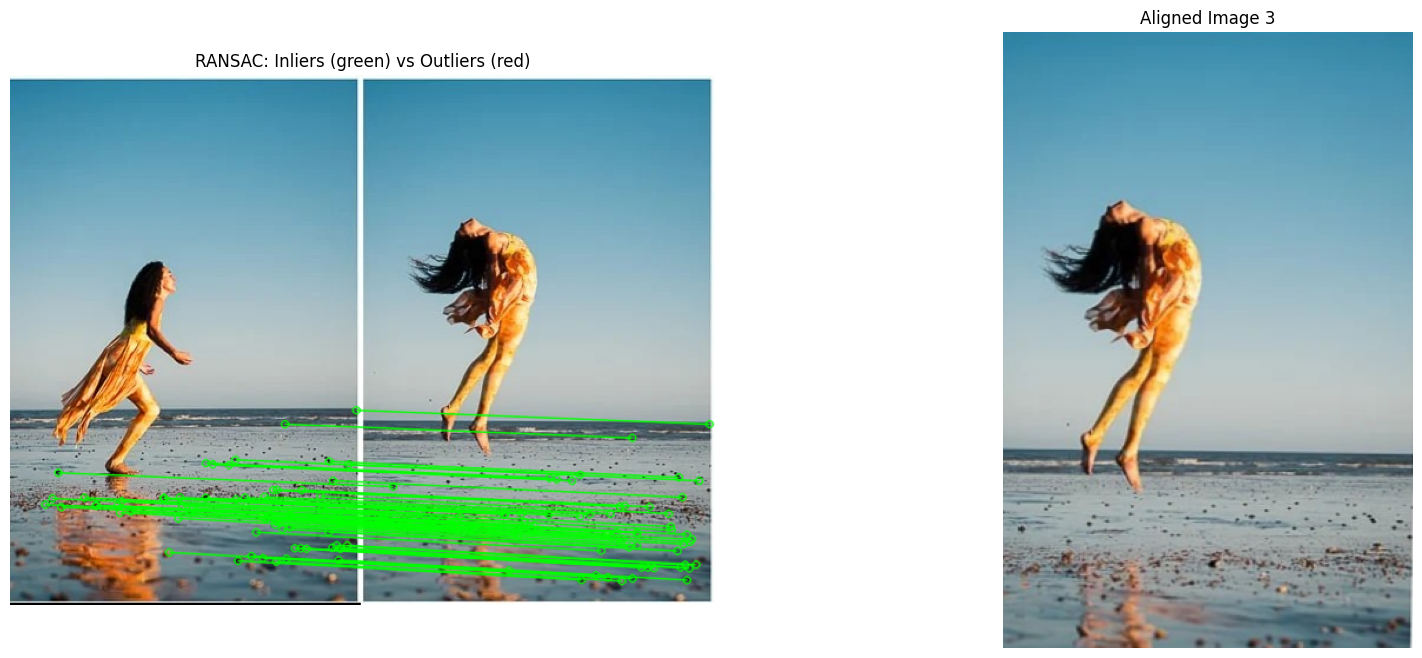

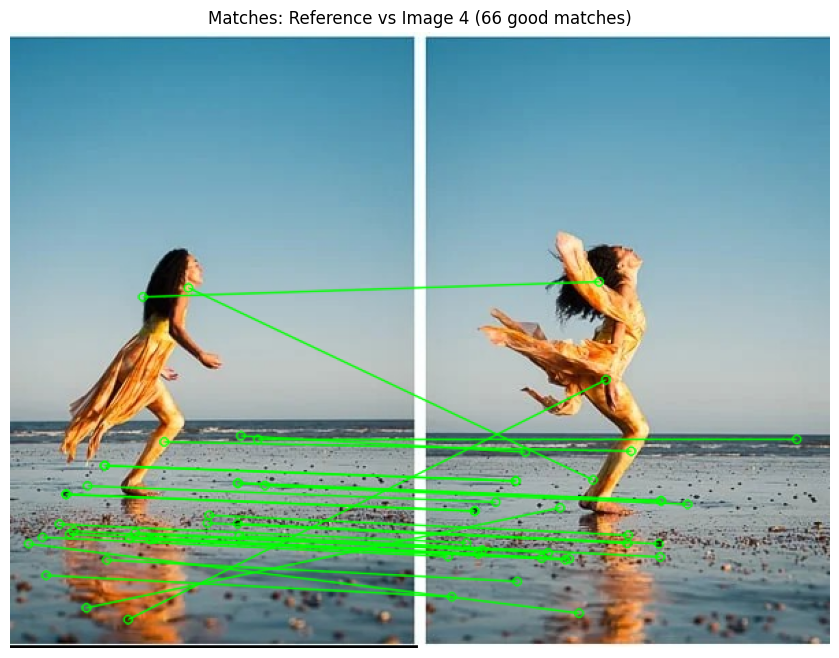


Part 3: RANSAC Transform for Image 4


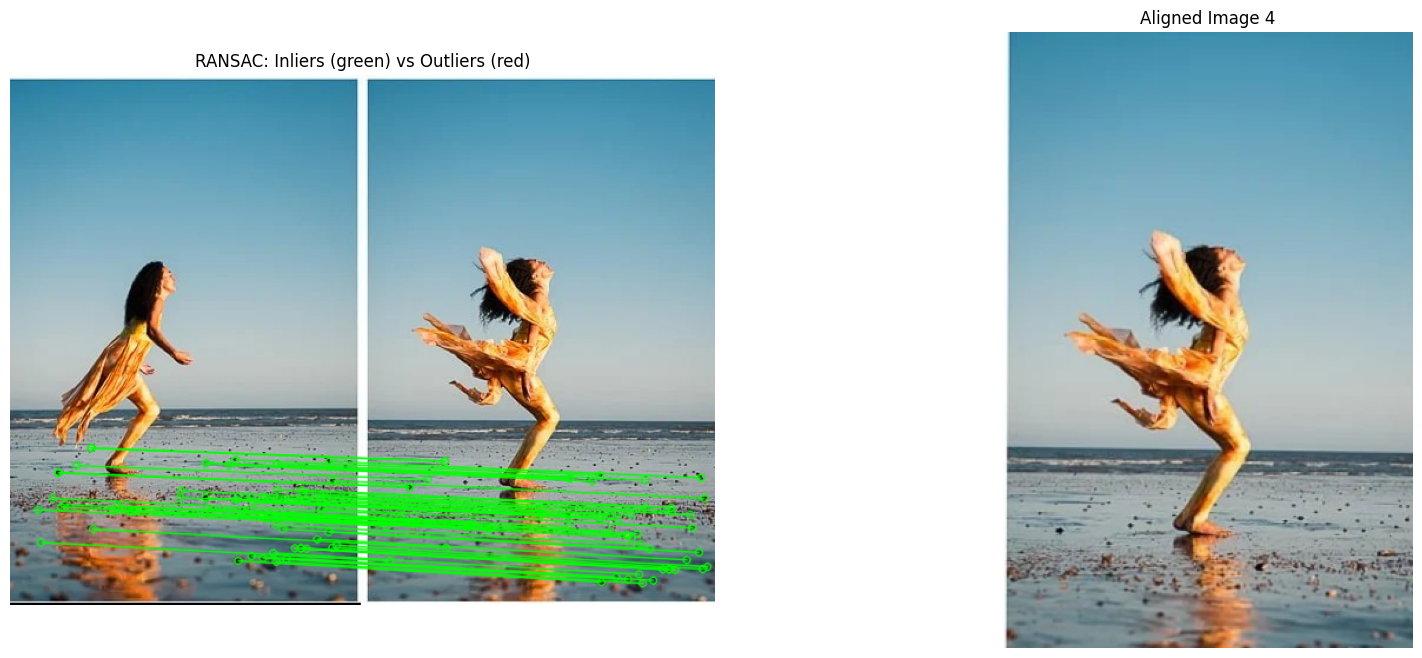


Part 4: Creating Animation


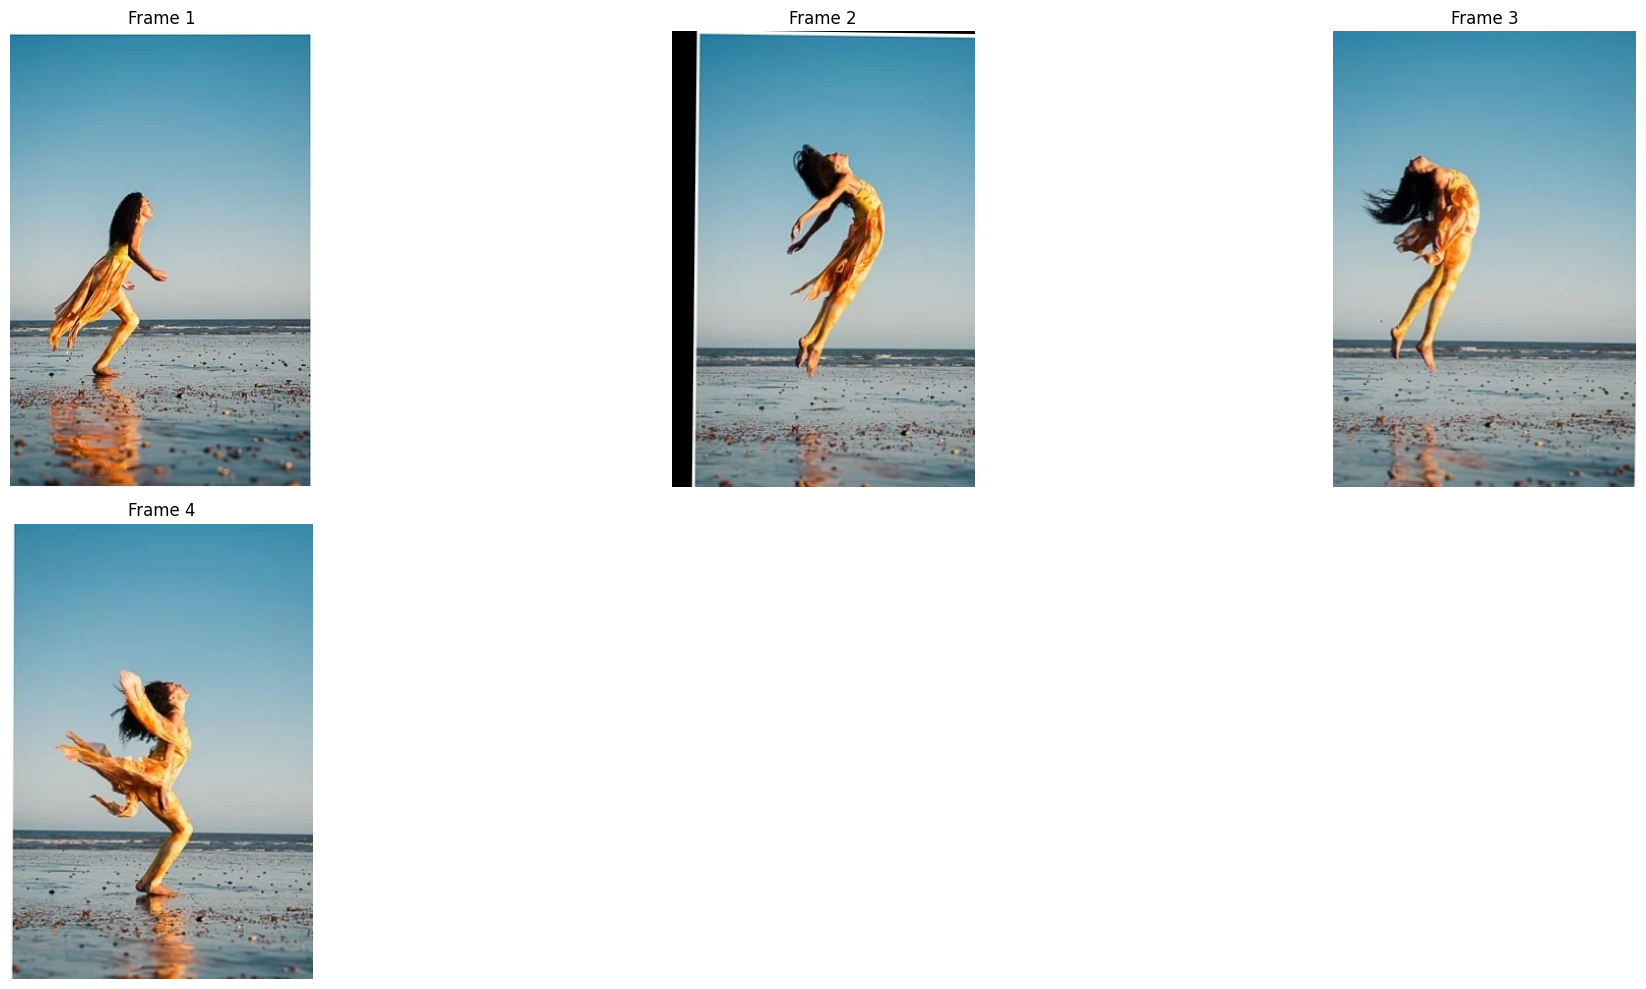


Process complete! Animation saved as Girl animation.gif


In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def load_images(image_paths):
    """Load multiple images and convert to RGB."""
    images = []
    for path in image_paths:
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append(img)
    return images

def process_tennis_sequence(image_paths):
    """Process entire sequence of tennis ball images."""
    print("Loading images...")
    images = load_images(image_paths)
    base_img = images[0]
    aligned_images = [base_img]
    # 1. Feature Extraction for all images
    print("\nPart 1: Extracting Features")
    sift = cv2.SIFT_create()
    all_keypoints = []
    all_descriptors = []
    plt.figure(figsize=(20, 10))
    for idx, img in enumerate(images):
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        kp, desc = sift.detectAndCompute(gray, None)
        all_keypoints.append(kp)
        all_descriptors.append(desc)
        # Visualize features
        img_with_kp = cv2.drawKeypoints(
            img, kp, None,
            flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS,
            color=(0, 255, 0)
        )
        plt.subplot(2, 3, idx+1)
        plt.imshow(img_with_kp)
        plt.title(f'Features Image {idx+1}\n({len(kp)} keypoints)')
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    # 2. Feature Matching between consecutive frames
    print("\nPart 2: Feature Matching")
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    for idx in range(1, len(images)):
        # Match features
        matches = flann.knnMatch(all_descriptors[0], all_descriptors[idx], k=2)
        # Apply ratio test
        good_matches = []
        for m, n in matches:
            if m.distance < 0.75 * n.distance:
                good_matches.append(m)
        # Visualize matches
        match_img = cv2.drawMatches(
            images[0], all_keypoints[0],
            images[idx], all_keypoints[idx],
            good_matches[:30], None,
            flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS,
            matchColor=(0, 255, 0),
            singlePointColor=(255, 0, 0)
        )
        plt.figure(figsize=(15, 8))
        plt.imshow(match_img)
        plt.title(f'Matches: Reference vs Image {idx+1} ({len(good_matches)} good matches)')
        plt.axis('off')
        plt.show()
        # 3. RANSAC Transform
        print(f"\nPart 3: RANSAC Transform for Image {idx+1}")
        src_pts = np.float32([all_keypoints[0][m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([all_keypoints[idx][m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 4.0)
        matchesMask = mask.ravel().tolist()
        # Draw RANSAC results
        draw_params = dict(
            matchColor=(0, 255, 0),
            singlePointColor=None,
            matchesMask=matchesMask,
            flags=2
        )
        ransac_img = cv2.drawMatches(
            images[0], all_keypoints[0],
            images[idx], all_keypoints[idx],
            good_matches, None,
            **draw_params
        )
        # Apply transformation
        h, w = base_img.shape[:2]
        aligned = cv2.warpPerspective(images[idx], M, (w, h))
        aligned_images.append(aligned)
        # Show RANSAC and alignment results
        plt.figure(figsize=(20, 8))
        plt.subplot(121)
        plt.imshow(ransac_img)
        plt.title('RANSAC: Inliers (green) vs Outliers (red)')
        plt.axis('off')
        plt.subplot(122)
        plt.imshow(aligned)
        plt.title(f'Aligned Image {idx+1}')
        plt.axis('off')
        plt.show()
    # 4. Create final animation
    print("\nPart 4: Creating Animation")
    pil_images = [Image.fromarray(img) for img in aligned_images]
    # Save as GIF
    output_path = 'Girl animation.gif'
    pil_images[0].save(
        output_path,
        save_all=True,
        append_images=pil_images[1:],
        duration=200,
        loop=0
    )
    # Show all frames in final sequence
    plt.figure(figsize=(20, 10))
    for idx, img in enumerate(aligned_images):
        plt.subplot(2, 3, idx+1)
        plt.imshow(img)
        plt.title(f'Frame {idx+1}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    print(f"\nProcess complete! Animation saved as {output_path}")
    return aligned_images

# Example usage
image_paths = [
    'Action 1.png',
    'Action 2.png',
    'Action 3.png',
    'Action 4.png',

]

# Run the complete pipeline
aligned_images = process_tennis_sequence(image_paths)